In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка
news = pd.read_csv('C:/Users/makbu/OneDrive/Desktop/hak/data/train_news.csv')
candles = pd.read_csv('C:/Users/makbu/OneDrive/Desktop/hak/data/train_candles.csv')

print(f"\nНовости: {len(news)} строк")
print(f"Котировки: {len(candles)} строк")

print("\nКолонки новостей:")
print(news.columns.tolist())

print("\nТипы данных:")
print(news.dtypes)

print("\nПропуски:")
print(news.isnull().sum())

print("\nПервые 3 новости:")
for i in range(3):
    print(f"\n--- Новость {i+1} ---")
    print(f"Дата: {news.iloc[i]['publish_date']}")
    print(f"Заголовок: {news.iloc[i]['title']}")
    print(f"Текст (первые 200 символов): {str(news.iloc[i]['publication'])[:200]}...")

# Распределение по времени
news['publish_date'] = pd.to_datetime(news['publish_date'])
print(f"\nПериод новостей: {news['publish_date'].min()} - {news['publish_date'].max()}")

# Количество новостей по месяцам
news['month'] = news['publish_date'].dt.to_period('M')
print("\nНовостей по месяцам:")
print(news['month'].value_counts().sort_index())

# Тикеры в котировках
print("\nТикеры в котировках:")
print(candles['ticker'].unique())
print(f"Всего уникальных тикеров: {candles['ticker'].nunique()}")


Новости: 24127 строк
Котировки: 23118 строк

Колонки новостей:
['Unnamed: 0', 'publish_date', 'title', 'publication']

Типы данных:
Unnamed: 0       int64
publish_date    object
title           object
publication     object
dtype: object

Пропуски:
Unnamed: 0      0
publish_date    0
title           0
publication     0
dtype: int64

Первые 3 новости:

--- Новость 1 ---
Дата: 2020-01-01 14:00:00
Заголовок: Ключевые российские нефтегазовые компании смотрятся выгодно относительно аналогов
Текст (первые 200 символов): Тенденции в отрасли. Ключевые российские нефтегазовые компании смотрятся выгодно относительно аналогов с развитых и развивающихся рынков как на операционном, так и на финансовом уровнях. Можно отметит...

--- Новость 2 ---
Дата: 2020-01-02 15:00:00
Заголовок: ММК выгодно отличает высокая экспозиция на внутренний рынок
Текст (первые 200 символов): Тенденции в отрасли. Ключевые российские сталелитейные компании сохраняют конкурентоспособность на операционном и финансовом уровн

Найдено дивидендных новостей: 0
После удаления дивидендов осталось: 20006 новостей
Удаляем 0 новостей за период 2020-03-01 - 2020-05-01
Удаляем 0 новостей за период 2022-02-24 - 2022-04-01
Удаляем 0 новостей за период 2023-06-23 - 2023-06-25
Удаляем 0 новостей за период 2023-03-10 - 2023-03-12
Удаляем 0 новостей за период 2023-10-07 - 2023-10-8

Новостей по месяцам:
year_month
2020-01    277
2020-02    456
2020-05    315
2020-06    377
2020-07    457
2020-08    399
2020-09    403
2020-10    401
2020-11    389
2020-12    454
2021-01    276
2021-02    477
2021-03    514
2021-04    629
2021-05    534
2021-06    595
2021-07    622
2021-08    579
2021-09    655
2021-10    667
Freq: M, Name: count, dtype: int64


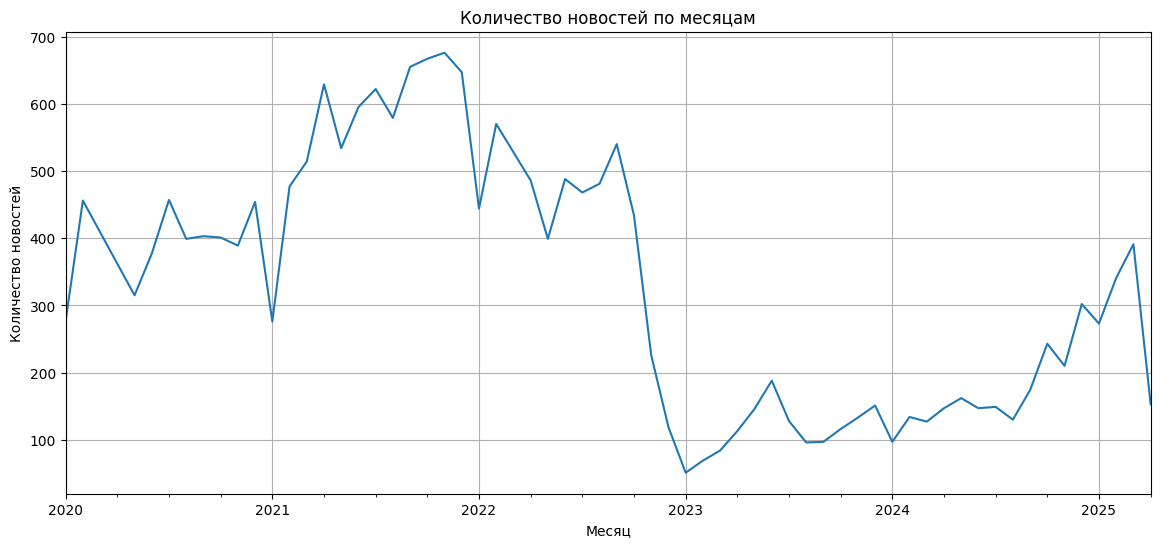

In [82]:
# Удаляем экстремальные периоды (лебедей)
black_swan_periods = [
    ('2020-03-01', '2020-05-01'),  # COVID паника
    ('2022-02-24', '2022-04-01'),  # начало СВО
    ('2023-06-23', '2023-06-25'),  # путч
    ('2023-03-10', '2023-03-12'),  # крах silicon valley bank
    ('2023-10-07', '2023-10-8'),   # израиль-хамас 
]

# Ключевые слова для дивидендов
dividend_keywords = [
    'дивиденд', 'dividend', 'выплат', 'дивы', 
    'реестр акционеров', 'отсечка', 'экс-дивидендная дата'
]

def is_dividend_news(text):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(kw in text_lower for kw in dividend_keywords)

# Помечаем дивидендные новости
news['is_dividend'] = news['title'].apply(is_dividend_news)

print(f"Найдено дивидендных новостей: {news['is_dividend'].sum()}")

# Убираем их ДО финального объединения тикеров
news = news[~news['is_dividend']].copy()

print(f"После удаления дивидендов осталось: {len(news)} новостей")


for start, end in black_swan_periods:
    mask = (news['publish_date'] >= start) & (news['publish_date'] <= end)
    print(f"Удаляем {mask.sum()} новостей за период {start} - {end}")
    news = news[~mask]
# Конвертируем в datetime
news['publish_date'] = pd.to_datetime(news['publish_date'])

# Группируем по месяцам
news['year_month'] = news['publish_date'].dt.to_period('M')
monthly_counts = news['year_month'].value_counts().sort_index()

print("\nНовостей по месяцам:")
print(monthly_counts.head(20))

# График
import matplotlib.pyplot as plt
monthly_counts.plot(kind='line', figsize=(14, 6))
plt.title('Количество новостей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество новостей')
plt.grid(True)
plt.show()

In [83]:
# Создаем словарь тикеров
ticker_names = {
    'SBER': ['сбербанк', 'сбер', 'sberbank', 'sber', 'sb ', 'сб ','сбера', 'министерство финансов', 'греф', 'сберу', 'сбербанку'],
    
    'GAZP': ['газпром', 'gazprom', 'газа', 'ogzpy', 'газпрома', 'миллер','сила сибири', 'сахалин', 'соболево', 'газпрому'],
    
    'LKOH': ['лукойл', 'lukoil', 'lukoy', 'лукойла', 'воробьев', 'воробьёв', 'лукойлу'],
    
    'GMKN': ['норникель', 'норильский никель', 'norilsk', 'норильск', 'gmk', 'горно-металлургическая', 'потанин','норникелю', 'норильскому никелю'],
    
    'NVTK': ['новатэк', 'novatek', 'новатэка', 'новатека', 'михельсон', 'новатэку', 'новатеку'],
    
    'ROSN': ['роснефть', 'rosneft', 'игорь сечин', 'сечин','роснефти'], 
    
    'VTBR': ['втб', 'vtb', 'внешторгбанк', 'костин'], 
    
    'MTSS': ['мтс', 'mts', 'мобильные телесистемы', 'mobile telesystems', 'афк система', 'мтс-банк','юрент'],
    
    'MAGN': ['магнитогорский', 'ммк', 'магнитка', 'magnitogorsk', 'рашников'],

    'ALRS': ['алроса', 'alrosa', 'алмазы', 'алмазная', 'маринычев', 'алросе'],
    
    'PLZL': ['полюс', 'polyus', 'золото', 'полюс золото', 'сулейман', 'керимов','полюсу'],
    
    'CHMF': ['северсталь', 'severstal', 'мордашов'],  
    
    'MOEX': ['мосбиржа', 'московская биржа', 'moex', 'биржа', 'жидков'],
    
    'MGNT': ['магнит', 'magnit', 'магнита', 'ритейл', 'галицкий', 'магнит альянс', 'галактиковна'],
    
    'PHOR': ['фосагро', 'phosagro', 'удобрения', 'гильгенберг'],
    
    'RUAL': ['русал', 'rusal', 'алюминий', 'дерипаска'],  
    
    'AFLT': ['аэрофлот', 'aeroflot', 'авиакомпания', 'савельев'], 
    
    'SIBN': ['газпром нефть', 'gazprom neft', 'газпромнефть', 'дочка газпрома'],
    
    'T': ['тинькофф', 'tinkoff', 'тиньков', 'tcs', 'ткс групп', 'тиньк', 'тбанк', 'т-банк', 'tcs group', 'tcs group holding PLC','тбанку','т-банку', 'тинькову', 'тинькоффу']
}

# Функция поиска
def find_tickers_in_text(text):
    if pd.isna(text):
        return []
    text_lower = str(text).lower()
    found = []
    for ticker, names in ticker_names.items():
        if any(name in text_lower for name in names):
            found.append(ticker)
    return found

# Ищем в заголовках и текстах
news['found_in_title'] = news['title'].apply(find_tickers_in_text)
news['found_in_text'] = news['publication'].apply(find_tickers_in_text)

# Объединяем (берем из заголовка, если есть, иначе из текста)
news['matched_tickers'] = news.apply(
    lambda row: row['found_in_title'] if len(row['found_in_title']) > 0 else row['found_in_text'],
    axis=1
)

# Статистика
news['has_ticker'] = news['matched_tickers'].apply(lambda x: len(x) > 0)
print(f"\nНовостей с найденными тикерами: {news['has_ticker'].sum()} ({news['has_ticker'].mean()*100:.1f}%)")
print(f"Новостей без тикеров: {(~news['has_ticker']).sum()}")

# Распределение по тикерам
from collections import Counter
all_tickers = [ticker for tickers in news['matched_tickers'] for ticker in tickers]
ticker_counts = Counter(all_tickers)
print("\nУпоминаемость компаний:")
for ticker, count in ticker_counts.most_common(19):
    print(f"{ticker}: {count} новостей")


Новостей с найденными тикерами: 17733 (88.6%)
Новостей без тикеров: 2273

Упоминаемость компаний:
GAZP: 5095 новостей
SBER: 2751 новостей
VTBR: 2404 новостей
LKOH: 1473 новостей
PLZL: 1389 новостей
ROSN: 1317 новостей
MGNT: 1160 новостей
MOEX: 1136 новостей
RUAL: 1093 новостей
GMKN: 1073 новостей
AFLT: 1050 новостей
NVTK: 1018 новостей
ALRS: 902 новостей
MAGN: 831 новостей
MTSS: 813 новостей
PHOR: 749 новостей
CHMF: 618 новостей
SIBN: 474 новостей
T: 453 новостей


In [84]:
# После маппинга компаний
news['has_ticker'] = news['matched_tickers'].apply(lambda x: len(x) > 0)

# ШАГ 3: Объединение тикеров (ЭТО ПРОПУЩЕНО У ТЕБЯ!)
all_tickers_list = list(ticker_names.keys())

def get_final_tickers(row):
    if row['is_market_wide']:
        return all_tickers_list  # все 19 тикеров
    elif len(row['matched_tickers']) > 0:
        return row['matched_tickers']  # найденные компании
    else:
        return []  # нет тикеров

news['final_tickers'] = news.apply(get_final_tickers, axis=1)
news['has_final_ticker'] = news['final_tickers'].apply(lambda x: len(x) > 0)

# ТЕПЕРЬ разделяем
market_news = news[news['is_market_wide']].copy()
company_news = news[~news['is_market_wide'] & news['has_final_ticker']].copy()

In [87]:
# Маппинг тикеров (твой код без изменений)
news['matched_tickers'] = news.apply(
    lambda row: row['found_in_title'] if len(row['found_in_title']) > 0 else row['found_in_text'],
    axis=1
)
news['has_ticker'] = news['matched_tickers'].apply(lambda x: len(x) > 0)

# Общерыночные ключевые слова
market_keywords = [
    'ставка цб', 'ключевая ставка', 'центробанк', 'набиуллина',
    'санкции', 'санкций', 'санкционн',
    'курс рубля', 'рубль', 'доллар', 'валют',
    'инфляци',
    'индекс мосбиржи', 'ммвб', 
    'нефть', 'brent', 'брент', 'urals', 'опек', 'опек+',
    'цены на энергоносители'
]

def has_market_news(text):
    if pd.isna(text):
        return False
    text_lower = str(text).lower()
    return any(kw in text_lower for kw in market_keywords)

news['is_market_wide'] = news['publication'].apply(has_market_news)

# КРИТИЧНО: Создаем final_tickers ПЕРЕД разделением
all_tickers_list = list(ticker_names.keys())

def get_final_tickers(row):
    if row['is_market_wide']:
        return all_tickers_list
    elif len(row['matched_tickers']) > 0:
        return row['matched_tickers']
    else:
        return []

news['final_tickers'] = news.apply(get_final_tickers, axis=1)
news['has_final_ticker'] = news['final_tickers'].apply(lambda x: len(x) > 0)

# Статистика перед разделением
print(f"Всего новостей: {len(news)}")
print(f"С найденными тикерами (has_ticker): {news['has_ticker'].sum()}")
print(f"Общерыночных (is_market_wide): {news['is_market_wide'].sum()}")
print(f"С финальными тикерами (has_final_ticker): {news['has_final_ticker'].sum()}")

# Теперь разделяем
market_news = news[news['is_market_wide']].copy()
company_news = news[~news['is_market_wide'] & news['has_final_ticker']].copy()

print(f"\nПосле разделения:")
print(f"Общерыночных: {len(market_news)}")
print(f"Компанейских: {len(company_news)}")

# Explode только компанейских
company_exploded = company_news.explode('final_tickers').rename(columns={'final_tickers': 'ticker'})
company_exploded['news_type'] = 'company_specific'

market_news['ticker'] = 'ALL'
market_news['news_type'] = 'market_wide'

# Объединяем
news_for_llm = pd.concat([
    market_news[['title', 'publication', 'publish_date', 'ticker', 'news_type']],
    company_exploded[['title', 'publication', 'publish_date', 'ticker', 'news_type']]
]).sort_values('publish_date').reset_index(drop=True)

print(f"\nИТОГО:")
print(f"Общерыночных строк: {(news_for_llm['ticker'] == 'ALL').sum()}")
print(f"Компанейских строк: {(news_for_llm['ticker'] != 'ALL').sum()}")
print(f"ВСЕГО: {len(news_for_llm)}")

news_for_llm.to_csv('news_for_llm.csv', index=False)

Всего новостей: 20006
С найденными тикерами (has_ticker): 17733
Общерыночных (is_market_wide): 8849
С финальными тикерами (has_final_ticker): 18788

После разделения:
Общерыночных: 8849
Компанейских: 9939

ИТОГО:
Общерыночных строк: 8849
Компанейских строк: 10693
ВСЕГО: 19542


In [88]:
# Берем каждую 100-ю строку
test_sample = news_for_llm.iloc[::100].copy()

print(f"Тестовая выборка: {len(test_sample)} строк")
print(f"Полный датасет: {len(news_for_llm)} строк")
print(f"\nПримеры из теста:")
print(test_sample[['title', 'ticker', 'news_type']].head(10))

# Сохраним для проверки
test_sample.to_csv('test_sample.csv', index=False)

Тестовая выборка: 196 строк
Полный датасет: 19542 строк

Примеры из теста:
                                                 title ticker  \
0    Ключевые российские нефтегазовые компании смот...    ALL   
100  Акции "Норникеля" продолжают обновлять историч...    ALL   
200                    Будет ли "Магнит" расти дальше?    ALL   
300  Давид Мелик-Гусейнов займется развитием медици...   SBER   
400  "АЛРОСА" в январе 2020 года нарастила продажи ...   ALRS   
500           В акциях "Норникеля" намечается разворот    ALL   
600  Главбух "Газпрома" Михаил Россеев избран в пра...   GAZP   
700  Смягчение политики ЦБ РФ создает предпосылки д...   VTBR   
800  "Аэрофлот" перенес сбор заявок на облигации се...    ALL   
900  События предстоящего дня: Qiwi отчитается за 1...   GAZP   

            news_type  
0         market_wide  
100       market_wide  
200       market_wide  
300  company_specific  
400  company_specific  
500       market_wide  
600  company_specific  
700  company_spec